In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats
import seaborn as sns
%matplotlib inline

In [2]:
# Set errorbar style
mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 1

In [3]:
with open('incent_results.json') as f:
    incent = json.load(f)
    
with open('non_incent_results.json') as f:
    non_incent = json.load(f)

In [4]:
def reshape_samples(samples):
    return { k: [sample[k] for sample in samples] for k in samples[0].keys()}

In [5]:
incent = reshape_samples(incent)
non_incent = reshape_samples(non_incent)

In [6]:
categories = [c['main_category'] for c in incent['avg_length_by_category'][0]]
price_tiers = [c['price_tier'] for c in incent['num_reviews_by_price_tier'][0]]

In [7]:
def reshape_grouped_by_category(data):
    return {c: [group['_c1'] for sample in data for group in sample if group['main_category'] == c] for c in categories}

In [8]:
incent_by_category = {k: reshape_grouped_by_category(v) for k, v in incent.items() if k.endswith('by_category')}
non_incent_by_category = {k: reshape_grouped_by_category(v) for k, v in non_incent.items() if k.endswith('by_category')}

In [9]:
def reshape_grouped_by_price_tier(data):
    return {t: [group['_c1'] for sample in data for group in sample if group['price_tier'] == t] for t in price_tiers}

In [10]:
incent_by_price_tier = {k: reshape_grouped_by_price_tier(v) for k, v in incent.items() if k.endswith('by_price_tier')}
non_incent_by_price_tier = {k: reshape_grouped_by_price_tier(v) for k, v in non_incent.items() if k.endswith('by_price_tier')}

In [11]:
def reshape_grouped_by_overall(data):
    return {o: [group['_c1'] for sample in data for group in sample if group['overall'] == o] for o in range(1, 6)}

In [12]:
incent_by_overall = {k: reshape_grouped_by_overall(v) for k, v in incent.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}
non_incent_by_overall = {k: reshape_grouped_by_overall(v) for k, v in non_incent.items() \
                     if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}

In [13]:
def confidence_interval(estimates, confidence=0.95):
    """Return a statistic and its confidence interval of a sequence using bootstrap resampling.
    Computes the statistic over count bootstrap samples drawn from the data, then computes the 
    lower and uppper bounds of the confidence interval.
    """
    # Calculate the confidence interval bounds assuming a normal distribution in
    # the estimates
    m, se = np.mean(estimates), np.std(estimates)
    lower, upper = scipy.stats.norm.interval(confidence, loc=m, scale=se)
    
    return m, lower, upper

def dict_barplot(data, errs, ax=None):
    if ax is None:
        ax = plt.subplot()
    data.plot(kind='bar', ax=ax, yerr=errs, fontsize = 14)

def plot_with_conf_interval(data_incent, data_non_incent, confidence=0.95, ax=None):
    conf_incent = {k: confidence_interval(v, confidence) for k, v in data_incent.items()}
    means_incent = {k: v[0] for k, v in conf_incent.items()}
    errs_incent = {k: v[2] - v[1] for k, v in conf_incent.items()}
    
    conf_non_incent = {k: confidence_interval(v, confidence) for k, v in data_non_incent.items()}
    means_non_incent = {k: v[0] for k, v in conf_non_incent.items()}
    errs_non_incent = {k: v[2] - v[1] for k, v in conf_non_incent.items()}
    
    dict_barplot(pd.DataFrame({'Incentivized': means_incent, 'Non incentivized': means_non_incent}),
                 pd.DataFrame({'Incentivized': errs_incent, 'Non incentivized': errs_non_incent}), ax=ax) 

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


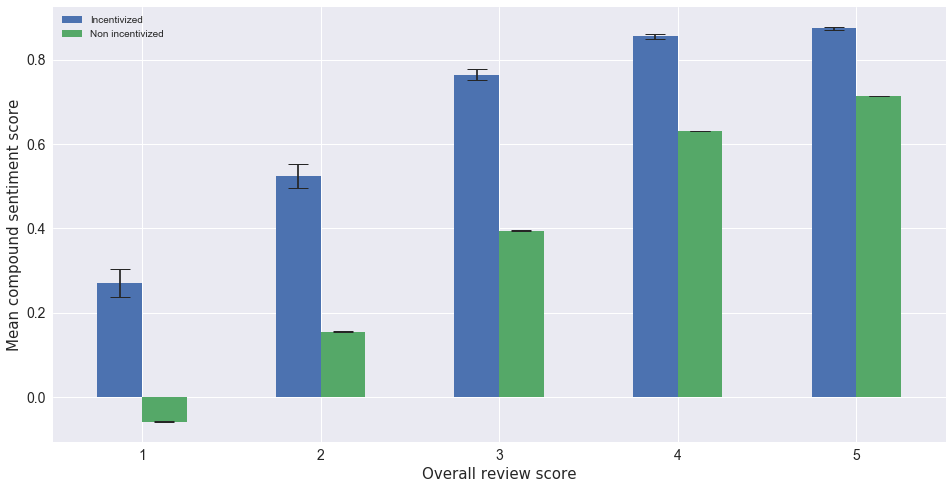

In [14]:
font = {'family' : 'normal',
        'size'   : 15}
_, ax1 = plt.subplots(figsize=(16, 8))
ax1.set_xlabel('Overall review score', font)
ax1.set_ylabel('Mean compound sentiment score', font)
plot_with_conf_interval(incent_by_overall['avg_compound_by_rating'], non_incent_by_overall['avg_compound_by_rating'], ax=ax1)
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


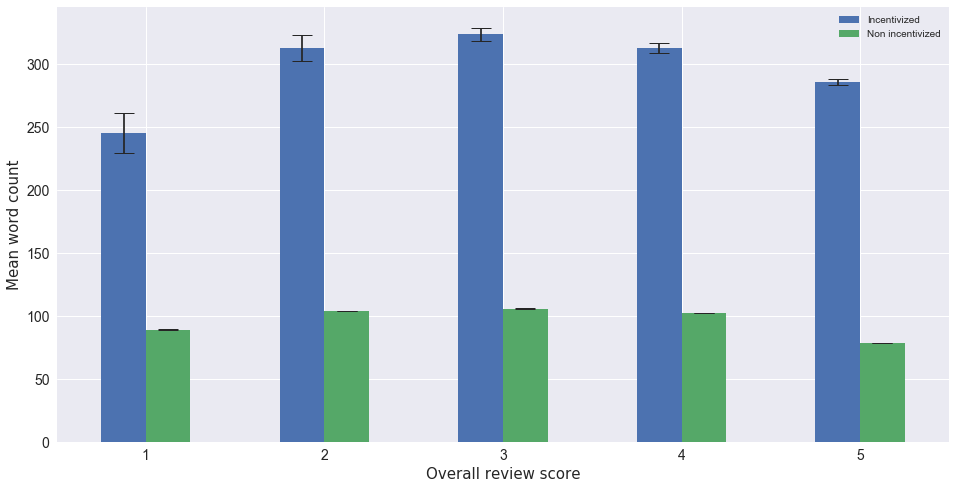

In [15]:
_, ax1 = plt.subplots(figsize=(16, 8))
ax1.set_xlabel('Overall review score', font)
ax1.set_ylabel('Mean word count', font)
plot_with_conf_interval(incent_by_overall['avg_length_by_overall'], non_incent_by_overall['avg_length_by_overall'], ax=ax1)
plt.xticks(rotation=0)